#$\color{green}{\textbf{Sentiment Analysis and Visualization}}$
---

**Filip Bancerz**

**Zofia Broszczak**

**Kamil Laskowski**

**Anna Lorenz**

#$\textbf{Packages}$
---

$\textbf{Installing libraries}$

In [ ]:
# !pip install openpyxl
# !pip install transformers
# !pip install torch
# !pip install transformers tqdm pandas
# !pip install wordcloud

$\textbf{Importing libraries}$

In [ ]:
import pandas as pd
from transformers import pipeline
from tqdm import tqdm
from transformers import BertTokenizer

import sqlite3
import csv
from datetime import date, timedelta

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

#$\textbf{Step 1: Data source}$
---

$\textbf{Opening the csv file from Google Drive and saving it into a dataframe under the name 'hotels'}$

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = '/content/drive/My Drive/7282_1.csv'
hotels = pd.read_csv(file_path)

$\textbf{Checking whether any review in the "reviews.text" column is empty}$

In [ ]:
empty_reviews = hotels['reviews.text'].isna() | (hotels['reviews.text'].str.strip() == '')
num_na_reviews = empty_reviews.sum()
print(num_na_reviews)

24


In [ ]:
hotels = hotels.dropna(subset=['reviews.text'])

$\textbf{Making sure that no review in the "reviews.text" column is empty}$

In [ ]:
empty_reviews = hotels['reviews.text'].isna() | (hotels['reviews.text'].str.strip() == '')
num_na_reviews = empty_reviews.sum()
print(num_na_reviews)

0


$\textbf{Checking whether any review in the "reviews.text" column is automatic}$

In [ ]:
automatic_reviews = (hotels['reviews.text'].str.strip() == 'to share your opinion of this businesswith YP visitors across the United Statesand in your neighborhood') | (hotels['reviews.text'].str.strip() == 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx')
num_auto_reviews = automatic_reviews.sum()
print(num_auto_reviews)

304


$\textbf{Dropping rows with automatic reviews}$

In [ ]:
hotels = hotels.drop(hotels[(hotels['reviews.text'].str.strip() == 'to share your opinion of this businesswith YP visitors across the United Statesand in your neighborhood') | (hotels['reviews.text'].str.strip() == 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx')].index)

$\textbf{Making sure that no review in the "reviews.text" column is automatic}$

In [ ]:
num_auto_reviews = automatic_reviews.sum()
print(num_auto_reviews)

0


$\textbf{Changing "reviews.rating" from 0 to 1}$

In [ ]:
hotels['reviews.rating'] = hotels['reviews.rating'].replace('0', '1')

$\textbf{Dropping rows with weird "reviews.rating" value (different from 1-5)}$

In [ ]:
hotels = hotels[hotels['reviews.rating'].isin({1, 2, 3, 4, 5})]

#$\textbf{Step 2: Sentiment analysis}$
---

Classify reviews as positive or negative.

**Tool:** Use a BERT model for text classification.

Use the **sentiment model** to get star rating, sentiment score and label.

Star rating ⭢ from 1 to 5

Sentiment score ⭢ from -1 for negative to +1 for positive

Sentiment label ⭢ classify the score into categories: Positive, Negative, Neutral.

*ChatGPT was used here (cell below) to help  us choose the right sentiment model. We knew we needed a multilingual model but did some research on different model outputs (sentiment scores / star ratings) and decided we would like both of those meassures so we chose a model that gives star ratings and mapped them to get sentiment scores (and labels) as well.

$\textbf{Loading a multilingual BERT Model which predicts star ratings}$


In [ ]:
sentiment_analyzer = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/669M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cpu


Transofrmer-based models (like BERT) have a fixed input lenght limit - 512 tokens. That is why we needed to truncate (shorten) the reviews that exceeded the limit.

Below, we are checking how many reviews have to be shortend to see whether it is an issue. If a lot of reviews have to be shortened, important information being deleted could cause incorrect sentiment analysis of longer reviews.

To write the code in the cell below, we used chat GPT. We needed help with tokenizing the text as we do not have much exerience on tokens.

In [ ]:
# Tokenizing text into the format required by our model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Defining function to count tokens in a review
def count_tokens(review):
    tokens = tokenizer.encode(review, add_special_tokens=True)
    return len(tokens)

# Applying the function to each review in the 'reviews.text' column
hotels['token_count'] = hotels['reviews.text'].apply(count_tokens)

# Counting how many reviews are over 512 tokens
num_reviews_over_512 = (hotels['token_count'] > 512).sum()
print(num_reviews_over_512)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (624 > 512). Running this sequence through the model will result in indexing errors


5


Since there is only 5 reviews that had to be shortened, it is not an issue worth considering. We can proceed with the analysis.

$\textbf{Analyzing sentiments}$

We first define a function to analyze each review's sentiment.

⭢ The function gives us star ratings (1-5 stars).

⭢ We map stars to get sentiment scores (from -1 to 1) using the model.

⭢ The function creates sentiment labels based on the scores. For score >= 0.5, the label is positive, for score <= -0.5, the label is negative and for scores between -0.5 and 0.5, the label is neutral.

In [ ]:
def analyze_sentiment(review):
    # Using the model to sentiment and shortening the reviews that are too long to 512 tokens
    result = sentiment_analyzer(review[:512])[0]

    label = result['label']
    stars = int(label.split()[0]) # Extracting the number of stars (1 to 5) - We used ChatGPT for this line as we wanted a quick and concise way of extracting the star number

    # Mapping stars to sentiments scores (range of -1 to +1)
    score_mapping = {
        1: -1,
        2: -0.5,
        3: 0,
        4: 0.5,
        5: 1,
    }
    score = score_mapping[stars]

    # Creating sentiment labels based on the sentiment score
    sentiment_label = (
        "Positive" if score >= 0.5 else
        "Negative" if score <= -0.5 else "Neutral"
    )

    return {"stars": stars, "score": score, "label": sentiment_label} # For easy use by other members of the group (because of access not by index)

$\textbf{Applying the "analyze_sentiment" function to each value in the "reviews.text" column with tqdm progress tracking}$


In [ ]:
tqdm.pandas()
sentiments = hotels['reviews.text'].progress_apply(analyze_sentiment)

100%|██████████| 34157/34157 [2:51:57<00:00,  3.31it/s]


$\textbf{Extracting scores and labels from each dictionary "x" from "sentiments" and putting these values in columns "sentiment_score" and "sentiment_label"}$

In [ ]:
hotels['sentiment_score'] = sentiments.apply(lambda x: x['score'])
hotels['sentiment_label'] = sentiments.apply(lambda x: x['label'])
hotels['star rating'] = sentiments.apply(lambda x: x['stars'])

In [ ]:
print(hotels[['reviews.text', 'star rating','sentiment_score', 'sentiment_label']])

                                            reviews.text  star rating  \
0      Pleasant 10 min walk along the sea front to th...            4   
1      Really lovely hotel. Stayed on the very top fl...            5   
2      Ett mycket bra hotell. Det som drog ner betyge...            4   
3      We stayed here for four nights in October. The...            5   
4      We stayed here for four nights in October. The...            5   
...                                                  ...          ...   
35905  We truly enjoyed staying at the Elk Springs re...            5   
35906  We were here for a 2nd time the last weekend o...            5   
35907  Best of the Best!!!! My family and I stayed in...            5   
35908  Amazing Vacation in Beautiful Cabin We stayed ...            5   
35909  My husband and I stayed at Tree Tops which is ...            4   

       sentiment_score sentiment_label  
0                  0.5        Positive  
1                  1.0        Positive  


$\textbf{Saving the datarame with added columns "sentiment_score" and "sentiment_label" to a CSV file with the name "hotels_with_sentiments"}$

In [ ]:
hotels.to_csv('hotels_with_sentiments_final.csv', index=False)

In [ ]:
hotels_with_sentiments = pd.read_csv("hotels_with_sentiments_final.csv")

$\textbf{Making sure that no review in the "reviews.text" column in the new DF is empty}$

In [ ]:
empty_reviews_sent = hotels_with_sentiments['reviews.text'].isna() | (hotels_with_sentiments['reviews.text'].str.strip() == '')
num_na_reviews_sent = empty_reviews_sent.sum()
print(num_na_reviews_sent)

0


#$\textbf{Step 3: SQL}$
---

$\textbf{Creating the SQLite database}$

In [ ]:
conn = sqlite3.connect('hotelsDB.db')
c = conn.cursor()

$\textbf{Resetting the database}$

In [ ]:
c.execute('DROP TABLE IF EXISTS Hotels')
c.execute('DROP TABLE IF EXISTS Users')
c.execute('DROP TABLE IF EXISTS Reviews')
c.execute('DROP TABLE IF EXISTS Date')

$\textbf{Creating the "Hotels" table to store hotel-related information}$

In [ ]:
c.execute('''
CREATE TABLE Hotels (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    name TEXT,
    address TEXT,
    categories TEXT,
    city TEXT,
    province TEXT,
    country TEXT,
    latitude REAL,
    longitude REAL,
    postalCode TEXT
)
''')

$\textbf{Creating the "Users" table to store user-related information}$

In [ ]:
c.execute('''
CREATE TABLE Users (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    username TEXT,
    userCity TEXT,
    userProvince TEXT
)
''')

$\textbf{Creating the "Reviews" table to store review-related data}$

In [ ]:
c.execute('''
CREATE TABLE Reviews (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    hotel_id INTEGER,
    user_id INTEGER,
    rating REAL,
    review_text TEXT,
    review_title TEXT,
    sentiment_score REAL,
    sentiment_label TEXT,
    star_rating REAL,
    review_date TEXT,
    FOREIGN KEY (hotel_id) REFERENCES Hotels (id),
    FOREIGN KEY (user_id) REFERENCES Users (id)
)
''')

$\textbf{Creating the "Date" table to store a range of dates (used for analysis)}$

In [ ]:
c.execute('''
CREATE TABLE Date (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    full_date TEXT
)
''')

$\textbf{Loading data from the CSV file and populating the database}$

*ChatGPT was used here (cell below) to help us load the data from csv files to databases in SQL. We decided to use chatGPT there as we encountered some issues in this step.

In [ ]:
with open("hotels_with_sentiments_final.csv", 'r', encoding='utf-8') as file:
    csv_reader = csv.reader(file)
    headers = next(csv_reader)
    for row in csv_reader:
      # Ensuring the row has the correct number of columns
        if len(row) == 23:
            c.execute('''
            INSERT INTO Hotels (name, address, categories, city, province, country, latitude, longitude, postalCode)
            VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?)
            ''', (row[6], row[0], row[1], row[2], row[8], row[3], row[4], row[5], row[7]))

            c.execute('''
            INSERT INTO Users (username, userCity, userProvince)
            VALUES (?, ?, ?)
            ''', (row[17], row[16], row[18]))

            # Getting the IDs of the newly inserted rows
            hotel_id = c.lastrowid
            user_id = c.lastrowid

            c.execute('''
            INSERT INTO Reviews (hotel_id, user_id, rating, review_text, review_title, sentiment_score, sentiment_label, star_rating, review_date)
            VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?)
            ''', (hotel_id, user_id, row[13], row[14], row[15], row[20], row[21], row[22], row[9]))
        else:
            print(f"Skipped row with incorrect number of columns: {row}")

# Populating the "Date" table
start_date = date(2002, 1, 1)
end_date = date(2017, 12, 31)
delta = timedelta(days=1)

current_date = start_date
while current_date <= end_date:
    c.execute('''
    INSERT INTO Date (full_date)
    VALUES (?)
    ''', (current_date.strftime('%Y-%m-%d'),))
    current_date += delta


conn.commit()

$\textbf{Displaying the structure and sample data for each table and counting null or empty values in each column of each table (additional data validation step)}$

*ChatGPT was used here (cell below) to help us validate the data loading process and make sure that previous steps were done correctly.

In [ ]:
# Displaying the structure and sample data for each table
print("\nTables in the database:")
c.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = c.fetchall()
for table in tables:
    print(f"\nTable: {table[0]}")

    c.execute(f"PRAGMA table_info({table[0]});")
    columns = c.fetchall()
    print("Structure of the table:")
    for column in columns:
        print(column)

    print("Sample data:")
    c.execute(f"SELECT * FROM {table[0]} LIMIT 10;")
    rows = c.fetchall()
    for row in rows:
        print(row)

# Counting null or empty values in each column of each table (additional data validation step)
def count_nulls_and_spaces(table_name):
    print(f"\nTable: {table_name}")
    c.execute(f"PRAGMA table_info({table_name});")
    columns = [col[1] for col in c.fetchall()]
    for column in columns:
        c.execute(f"SELECT COUNT(*) FROM {table_name} WHERE {column} IS NULL OR TRIM({column}) = '';")
        null_count = c.fetchone()[0]
        print(f"Column: {column}, Empty values: {null_count}")

print("\nEmpty values in tables:")
for table in tables:
    count_nulls_and_spaces(table[0]) # "userProvince" and "userCity" have a lot of empty values ​​- we leave them for now (if needed, it will be possible to correct it later in PowerBI)


conn.close()


Tables in the database:

Table: Hotels
Structure of the table:
(0, 'id', 'INTEGER', 0, None, 1)
(1, 'name', 'TEXT', 0, None, 0)
(2, 'address', 'TEXT', 0, None, 0)
(3, 'categories', 'TEXT', 0, None, 0)
(4, 'city', 'TEXT', 0, None, 0)
(5, 'province', 'TEXT', 0, None, 0)
(6, 'country', 'TEXT', 0, None, 0)
(7, 'latitude', 'REAL', 0, None, 0)
(8, 'longitude', 'REAL', 0, None, 0)
(9, 'postalCode', 'TEXT', 0, None, 0)
Sample data:
(1, 'Hotel Russo Palace', 'Riviera San Nicol 11/a', 'Hotels', 'Mableton', 'GA', 'US', 45.421611, 12.376187, '30126')
(2, 'Hotel Russo Palace', 'Riviera San Nicol 11/a', 'Hotels', 'Mableton', 'GA', 'US', 45.421611, 12.376187, '30126')
(3, 'Hotel Russo Palace', 'Riviera San Nicol 11/a', 'Hotels', 'Mableton', 'GA', 'US', 45.421611, 12.376187, '30126')
(4, 'Hotel Russo Palace', 'Riviera San Nicol 11/a', 'Hotels', 'Mableton', 'GA', 'US', 45.421611, 12.376187, '30126')
(5, 'Hotel Russo Palace', 'Riviera San Nicol 11/a', 'Hotels', 'Mableton', 'GA', 'US', 45.421611, 12.376

$\textbf{Exporting tables to CSV files}$

In [ ]:
conn = sqlite3.connect('hotelsDB.db')
c = conn.cursor()

# Exporting tables to a csv files
def export_table_to_csv(cursor, table_name, file_name):
    cursor.execute(f"SELECT * FROM {table_name}")
    rows = cursor.fetchall()
    column_names = [description[0] for description in cursor.description]

    with open(file_name, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(column_names)
        writer.writerows(rows)

export_table_to_csv(c, 'Hotels', 'Hotels.csv')
export_table_to_csv(c, 'Users', 'Users.csv')
export_table_to_csv(c, 'Reviews', 'Reviews.csv')
export_table_to_csv(c, 'Date', 'Date.csv')

conn.commit()
conn.close()

#$\textbf{Step 4: Visualization for PowerBI in Python}$
---

$\textbf{Loading the table with reviews}$

In [ ]:
table_reviews = pd.read_csv('Reviews.csv')

$\textbf{Creating column with review length for correlaction matrix}$

In [ ]:
table_reviews['review_length'] = table_reviews['review_text'].apply(len)

$\textbf{Creating correlation matrix}$

In [ ]:
correlation_matrix = table_reviews[['rating', 'star_rating', 'sentiment_score', 'review_length']].corr()

names = {
    'rating': 'Rating',
    'star_rating': 'Star rating',
    'sentiment_score': 'Sentiment score',
    'review_length': 'Review length'
}
correlation_matrix = correlation_matrix.rename(index = names, columns = names)

$\textbf{Correlation matrix}$

In [ ]:
print(correlation_matrix)

                   Rating  Star rating  Sentiment score  Review length
Rating           1.000000     0.698122         0.698122      -0.154115
Star rating      0.698122     1.000000         1.000000      -0.162830
Sentiment score  0.698122     1.000000         1.000000      -0.162830
Review length   -0.154115    -0.162830        -0.162830       1.000000


$\textbf{Creating our own colors :)}$

We know very well how to create a basic correlation matrix, but we used ChatGPT to match the colours of the matrix to the main colors of our visualisation in PowerBI:) ChatGPT advised us to use the seaborn.heatmap to use our colorway. The specific parameters of the heatmap (fmt = '.2f' and linewidths = 0.5) were chosen with the help of the seaborn.heatmap documentation https://seaborn.pydata.org/generated/seaborn.heatmap.html.

In [ ]:
# We know very well how to create a basic correlation matrix, but we used ChatGPT to match the colours of the matrix to the main colors of our visualisation in PowerBI:)
colors = [
    "#eef6f6",
    "#57a8a4",
    "#4f9995",
    "#234342"
]
teal_cmap = LinearSegmentedColormap.from_list("teal_cmap", colors)

$\textbf{Creating} \color{green}{\textbf{ heatmap }}$


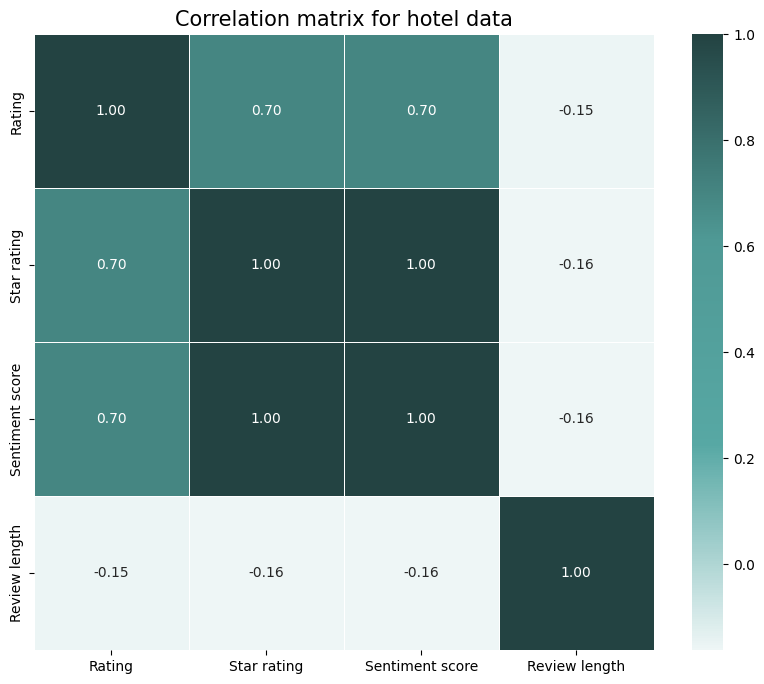

In [ ]:
plt.figure(figsize=(10, 8))

sns.heatmap(
    correlation_matrix,
    annot = True,
    cmap = teal_cmap,
    fmt = '.2f',
    linewidths = 0.5
)

plt.title('Correlation matrix for hotel data', fontsize = 15)
plt.show()

$\textbf{Creating a} \color{green}{\textbf{ word cloud }} \textbf{for positive reviews}$

We have some basic experience with word clouds but to refresh our memory, we relied on documentation from https://www.datacamp.com/tutorial/wordcloud-python

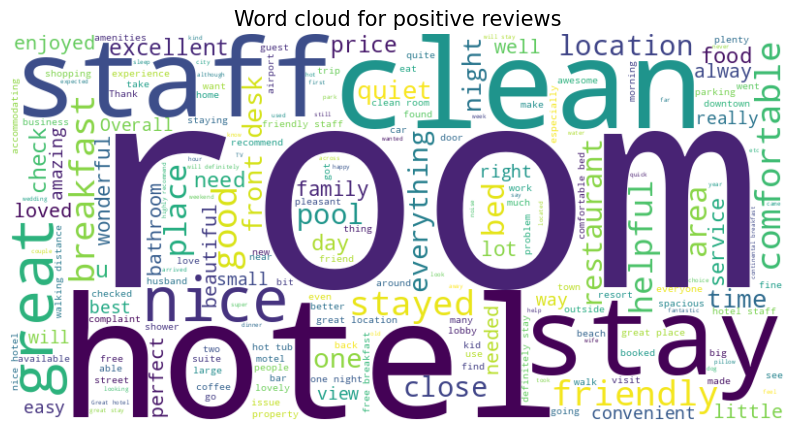

In [ ]:
positive_reviews = table_reviews[table_reviews['sentiment_label'] == 'Positive']['review_text']
positive_text = ' '.join(positive_reviews.dropna().tolist())

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word cloud for positive reviews', fontsize=15)
plt.show()

$\textbf{Creating} \color{green}{\textbf{ word cloud }} \textbf{for negative reviews}$

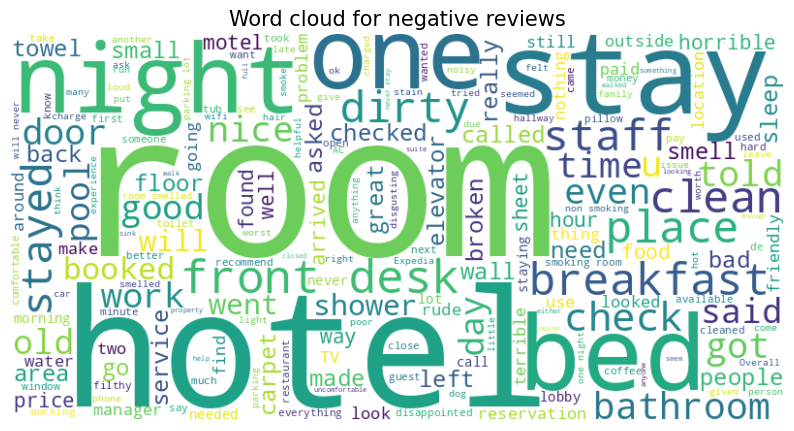

In [ ]:
negative_reviews = table_reviews[table_reviews['sentiment_label'] == 'Negative']['review_text']
negative_text = ' '.join(negative_reviews.dropna().tolist())

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word cloud for negative reviews', fontsize=15)
plt.show()

#$\textbf{Visualization description}$
---

$\color{green}{\textbf{ PowerBI }} \textbf{visualizations:}$

The Power BI dashboard provides an interactive overview of the hotel reviews dataset. It allows for in-depth analysis of sentiments, star ratings, and hotel-specific information. This is a concluding summary of the visualization options:

**1. Sentiment overview:**

The summary at the top provides a breakdown of the number of positive, neutral, and negative reviews. The percentage differences show how higher the average model’s star ratings are when compared to the average of the subjective users’ ratings.

**2. Filtering by date:**

The Date filter on the right allows users to choose specific years to analyze trends in reviews or star ratings for particular periods.

**3. Star rating histogram:**

The histogram at the bottom shows the distribution of star ratings across hotels. By selecting a specific star rating, users can filter the table above to view only the hotels with the selected rating.
This feature is useful for identifying high-performing hotels or analyzing those that need improvement.

**4. Hotel and City Filters:**

Users can narrow down the analysis by selecting a specific hotel name or city from the dropdown menus. This provides detailed insights into performance or reviews for certain locations or specific hotels.

**5. Table of Hotels:**

The table shows the hotels, their cities and their average star ratings allowing to compare their performance.
Combined with other filters, such as sentiment or date, this table allows for targeted analysis like identifying top-rated hotels in specific cities during a particular time.

**6. Map visualization:**

This map visualization provides an overview of the distribution of hotels based on sentiment labels (positive, neutral, and negative). It highlights customer sentiment patterns geographically, making it easier to identify trends.
By selecting specific sentiment categories (e.g., positive or negative), users can focus on how different regions perform in terms of guest satisfaction. For instance, clusters of red points (negative sentiment) indicate areas where hotel services need improvement, while green points (positive sentiment) showcase regions with high customer satisfaction.

*Comment: While creating the map, we identified issues related to the accuracy of the data. Specifically, the dataset contains errors in the recorded locations of hotels, resulting in some hotels being incorrectly displayed as located in cities outside the United States, despite their actual locations being within U.S. cities. Neither the postal codes nor the geographical coordinates provide reliable information, suggesting that these data points were likely generated automatically and are inaccurate.*

$\color{green}{\textbf{ Python }} \textbf{visualizations:}$

**1. Correlation matrix:**

The correlation between star ratings and review length is not strong at all. This means that there is no visible difference in length of negative and positive reviews. The correlation between Star rating and Sentiment score is equal to 1 which is understandable because the second one is created from the first one. The correlation between the rating given by the users and the Star rating created by our model is 0.7.

**2. Word clouds:**

The word clouds show that the most frequently mentioned words in both positive and negative reviews are "hotel" and "room". For positive reviews, words like "clean," "friendly," and "comfortable" highlight key strengths such as room cleanliness and good service. In negative reviews, while common words like "stay," "one," "bed," and "night" are more neutral, negative terms such as "dirty" stand out, pointing to issues with cleanliness.